In [2]:
import torch

In [3]:
import os
from PIL import Image
from torchvision import transforms
from torchvision.datasets import DatasetFolder
import cv2
import numpy as np


def load_image(img_path:str):    
        np_img = cv2.imread(img_path) #CV2 to open and convert BMP mages into NUMPY    
        #np_img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        return Image.fromarray(np_img)  #we need Image for the transforms to work correctly

dset = DatasetFolder(root='NEUdata', loader = load_image, extensions = ('.bmp',))


In [4]:
img_path = 'NEUdata/Cr/Cr_10.bmp'
np_img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
np_img = cv2.imread(img_path)

In [5]:
np_img_gray.shape

(200, 200)

In [6]:
np_img.shape

(200, 200, 3)

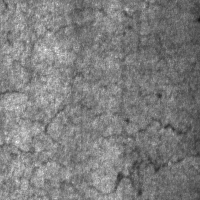

In [7]:
dset[10][0]

In [8]:
len(dset)

1800

In [9]:
data, label = dset[0]
print(type(data))

<class 'PIL.Image.Image'>


In [10]:
print(data)

<PIL.Image.Image image mode=RGB size=200x200 at 0x7F806447DE20>


#### We need to write a transform to make it compatible with AlexNet (size 224x224x3, and type tensor)

In [11]:
from torchvision import transforms

transform = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(
      mean=[0.485, 0.456, 0.406],
      std=[0.229, 0.224, 0.225])])

dset = DatasetFolder(root='NEUdata', loader = load_image, extensions = ('.bmp',), transform = transform)

### Note that load_image  needed to return a PIL.Image for the transforms to be correctly applied


In [12]:
data, label = dset[0]
print(type(data))
print(data)

<class 'torch.Tensor'>
tensor([[[ 1.3242,  1.3755,  1.7180,  ...,  0.1939, -0.1314, -0.1486],
         [ 1.1015,  0.9817,  1.1015,  ...,  0.2453, -0.0458, -0.0972],
         [ 0.8276,  0.7248,  0.9132,  ...,  0.1768,  0.1939,  0.1426],
         ...,
         [ 1.2728,  1.4954,  1.6838,  ...,  0.6392,  0.6221,  0.5878],
         [ 1.4440,  1.6838,  2.0777,  ...,  0.7248,  0.6049,  0.5707],
         [ 1.4440,  1.6153,  1.6838,  ...,  0.8447,  0.7248,  0.6392]],

        [[ 1.4832,  1.5357,  1.8859,  ...,  0.3277, -0.0049, -0.0224],
         [ 1.2556,  1.1331,  1.2556,  ...,  0.3803,  0.0826,  0.0301],
         [ 0.9755,  0.8704,  1.0630,  ...,  0.3102,  0.3277,  0.2752],
         ...,
         [ 1.4307,  1.6583,  1.8508,  ...,  0.7829,  0.7654,  0.7304],
         [ 1.6057,  1.8508,  2.2535,  ...,  0.8704,  0.7479,  0.7129],
         [ 1.6057,  1.7808,  1.8508,  ...,  0.9930,  0.8704,  0.7829]],

        [[ 1.6988,  1.7511,  2.0997,  ...,  0.5485,  0.2173,  0.1999],
         [ 1.4722,  1.

In [13]:
from torch.utils.data import random_split

train_set, val_set = random_split(
                      dset, 
                      [1200, 600])

trainloader = torch.utils.data.DataLoader(
                    train_set, 
                    batch_size=16, 
                    shuffle=True)

valloader = torch.utils.data.DataLoader(
                    val_set, 
                    batch_size=16, 
                    shuffle=True)

print(len(trainloader))
# out: 2500
print(len(valloader))
# out: 625

75
38


## In what units is the length of the loaders?

In [14]:
dd,ll = next(iter(trainloader))

In [15]:
dd.shape

torch.Size([16, 3, 224, 224])

In [16]:
print(dd)

tensor([[[[-0.3883, -0.3712, -0.4226,  ..., -0.0287,  0.0056,  0.0741],
          [-0.3712, -0.3027, -0.3712,  ..., -0.0116, -0.0287,  0.0569],
          [-0.3541, -0.3369, -0.3712,  ...,  0.0056, -0.0287,  0.0569],
          ...,
          [-0.2171, -0.1486, -0.1143,  ...,  0.4166,  0.3309,  0.2796],
          [-0.2171, -0.1999, -0.1657,  ...,  0.4508,  0.3994,  0.3481],
          [-0.2342, -0.1999, -0.1486,  ...,  0.5707,  0.3994,  0.3138]],

         [[-0.2675, -0.2500, -0.3025,  ...,  0.1001,  0.1352,  0.2052],
          [-0.2500, -0.1800, -0.2500,  ...,  0.1176,  0.1001,  0.1877],
          [-0.2325, -0.2150, -0.2500,  ...,  0.1352,  0.1001,  0.1877],
          ...,
          [-0.0924, -0.0224,  0.0126,  ...,  0.5553,  0.4678,  0.4153],
          [-0.0924, -0.0749, -0.0399,  ...,  0.5903,  0.5378,  0.4853],
          [-0.1099, -0.0749, -0.0224,  ...,  0.7129,  0.5378,  0.4503]],

         [[-0.0441, -0.0267, -0.0790,  ...,  0.3219,  0.3568,  0.4265],
          [-0.0267,  0.0431, -

 ### We are going to illustrate transfer learning now
Transfer starts with a pretrained model from the torchvision library. The pretrained model will be resnet18. This model is trained on ImageNet 1K (this is the default for resnet18: DEFAULT = IMAGENET1K_V1)
The fact that ImageNet consists of RGB images of size 224 x 224 demanded our data resizing in the transform

In [17]:
import torchvision.models as models
import torch.nn as nn
from torchinfo import summary

orig_model = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1)
summary(orig_model, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [16, 1000]                --
+ Conv2d: 1-1                            [16, 64, 112, 112]        9,408
+ BatchNorm2d: 1-2                       [16, 64, 112, 112]        128
+ ReLU: 1-3                              [16, 64, 112, 112]        --
+ MaxPool2d: 1-4                         [16, 64, 56, 56]          --
+ Sequential: 1-5                        [16, 64, 56, 56]          --
|    + BasicBlock: 2-1                   [16, 64, 56, 56]          --
|    |    + Conv2d: 3-1                  [16, 64, 56, 56]          36,864
|    |    + BatchNorm2d: 3-2             [16, 64, 56, 56]          128
|    |    + ReLU: 3-3                    [16, 64, 56, 56]          --
|    |    + Conv2d: 3-4                  [16, 64, 56, 56]          36,864
|    |    + BatchNorm2d: 3-5             [16, 64, 56, 56]          128
|    |    + ReLU: 3-6                    [16, 64, 56, 56]          --
|

### notice that the last layer of the resnet18 is a linear layer with output size 1000
Let's get rid of it, because we have only 6 classes!

Plus, add the FlattenLayer to see what is the linearized size of the last AvgPool

In [18]:
layers = list(orig_model.children())[:-1]  #get all the layers except the last one
layers.append(nn.Flatten())   
vec_model = nn.Sequential(*layers)
summary(vec_model, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [16, 512]                 --
+ Conv2d: 1-1                            [16, 64, 112, 112]        9,408
+ BatchNorm2d: 1-2                       [16, 64, 112, 112]        128
+ ReLU: 1-3                              [16, 64, 112, 112]        --
+ MaxPool2d: 1-4                         [16, 64, 56, 56]          --
+ Sequential: 1-5                        [16, 64, 56, 56]          --
|    + BasicBlock: 2-1                   [16, 64, 56, 56]          --
|    |    + Conv2d: 3-1                  [16, 64, 56, 56]          36,864
|    |    + BatchNorm2d: 3-2             [16, 64, 56, 56]          128
|    |    + ReLU: 3-3                    [16, 64, 56, 56]          --
|    |    + Conv2d: 3-4                  [16, 64, 56, 56]          36,864
|    |    + BatchNorm2d: 3-5             [16, 64, 56, 56]          128
|    |    + ReLU: 3-6                    [16, 64, 56, 56]          --
|

In [19]:
layers.append(nn.Linear(512,6))
vec_model = nn.Sequential(*layers)
summary(vec_model, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [16, 6]                   --
+ Conv2d: 1-1                            [16, 64, 112, 112]        9,408
+ BatchNorm2d: 1-2                       [16, 64, 112, 112]        128
+ ReLU: 1-3                              [16, 64, 112, 112]        --
+ MaxPool2d: 1-4                         [16, 64, 56, 56]          --
+ Sequential: 1-5                        [16, 64, 56, 56]          --
|    + BasicBlock: 2-1                   [16, 64, 56, 56]          --
|    |    + Conv2d: 3-1                  [16, 64, 56, 56]          36,864
|    |    + BatchNorm2d: 3-2             [16, 64, 56, 56]          128
|    |    + ReLU: 3-3                    [16, 64, 56, 56]          --
|    |    + Conv2d: 3-4                  [16, 64, 56, 56]          36,864
|    |    + BatchNorm2d: 3-5             [16, 64, 56, 56]          128
|    |    + ReLU: 3-6                    [16, 64, 56, 56]          --
|

### Alternatively, just replace model.fc with the linear layer

In [20]:
import copy
alt_model = copy.deepcopy(orig_model)
alt_model.fc = nn.Linear(512,6)

In [22]:
from torch import optim
from torch import nn
import torch.optim.lr_scheduler as lr_scheduler

criterion = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = vec_model.to(device)

optimizer = optim.SGD(model.parameters(), 
                      lr=0.001, 
                      momentum=0.9)
 
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.25, total_iters=10)


#from torch.utils.tensorboard import SummaryWriter



N_EPOCHS = 20
tr_loss_hist = []
val_loss_hist = []
for epoch in range(N_EPOCHS):

    # Training 
    train_loss = 0.0
    model.train() # <1>
    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    # Validation
    val_loss = 0.0
    model.eval() # <2>
    for inputs, labels in valloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        val_loss += loss.item()

    print("Epoch: {} Train Loss: {} Val Loss: {}".format(
                  epoch, 
                  train_loss/len(trainloader), 
                  val_loss/len(valloader)))
    tr_loss_hist.append(train_loss/len(trainloader))
    val_loss_hist.append(val_loss/len(valloader))

Epoch: 0 Train Loss: 0.8844652640819549 Val Loss: 0.3061034514715797
Epoch: 1 Train Loss: 0.26535396377245585 Val Loss: 0.1197584342015417
Epoch: 2 Train Loss: 0.14955311963955562 Val Loss: 0.0716430432114162
Epoch: 3 Train Loss: 0.11129661932587624 Val Loss: 0.055279145752520936
Epoch: 4 Train Loss: 0.07475427898267904 Val Loss: 0.03421526692660624
Epoch: 5 Train Loss: 0.07051506792505582 Val Loss: 0.0251087935543374
Epoch: 6 Train Loss: 0.0526858014985919 Val Loss: 0.021126756750929513
Epoch: 7 Train Loss: 0.056931778310487666 Val Loss: 0.024481892503038245
Epoch: 8 Train Loss: 0.044014159583797056 Val Loss: 0.016867204275178283
Epoch: 9 Train Loss: 0.05735302047803998 Val Loss: 0.01772044067987927
Epoch: 10 Train Loss: 0.037353627836952605 Val Loss: 0.015190954779666898
Epoch: 11 Train Loss: 0.04396736581809819 Val Loss: 0.014698376505341577
Epoch: 12 Train Loss: 0.02402854585709671 Val Loss: 0.011400432745607472
Epoch: 13 Train Loss: 0.021516622475658855 Val Loss: 0.010374135861638

Text(0.5, 1.0, 'Loss Curves')

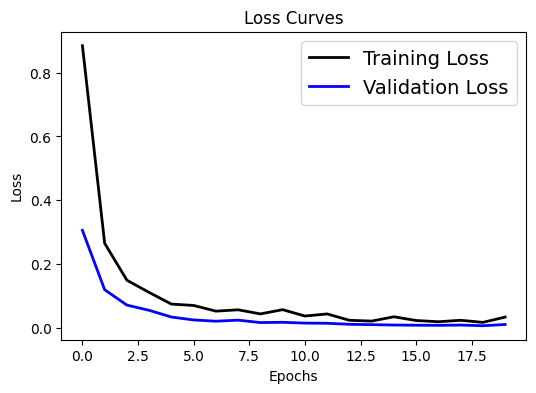

In [23]:
import matplotlib.pyplot as plt

# Plotting the loss curve
plt.figure(figsize=[6,4])
plt.plot(tr_loss_hist, 'black', linewidth=2.0)
plt.plot(val_loss_hist, 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)